# L7CA - Lesson7 CAM

2018/1/23 02:05

Continuation of L7CA_lesson7-cifar10.ipynb

Lecture: https://youtu.be/H3g26EVADgY?t=7340

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = 'data/dogscats/'
sz = 224
arch = resnet34
bs = 32

In [4]:
m = arch(True)

In [5]:
m

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

The version of resnet that happens to be the best is the preact resnet. They have different internal orderings of conv,pool,res,bn,relu,etc.

---

We want to take our standard resnet model here and finetune it for dogs and cats. So we need to remove the last layer: `(fc): Linear(in_features=512, out_features=1000)`

Using `ConvLearner.pretrained` in FastAI deleted the last two layers: 
```
(avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0, ceil_mode=False, count_include_pad=True)
  (fc): Linear(in_features=512, out_features=1000)
```

The FastAI library is also the first/only library to replace the penultimate layer with a concatenated Adaptive + Max pooling layer.

For this exercise we'll do a simple version where we grab all the children of the model, delete the last two layers, and add a convolution which just has two outputs. THen do a average pooling, and a softmax.

In [6]:
m = nn.Sequential(*children(m)[:-2],
                  nn.Conv2d(512, 2, 3, padding=1),
                  nn.AdaptiveAvgPool2d(1), Flatten(), # 2 layers here
                  nn.LogSoftmax())

This model won't have a Full layer at the end. Instaed, the last layer has a Conv2d which outputs 2 7x7 filters, which will go through average pooling and come out as 2 numbers. This is a different way of producing two output numbers.

The reason for this we can do Class Activation Maps -- we can ask the model which parts of an image happened to be important

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [9]:
learn = ConvLearner.from_model_data(m, data)

`nn.Conv2d(512, 2, 3, padding=1)` is the 4th from last layer, so we'll freeze up to it.

In [10]:
learn.freeze_to(-4)

In [11]:
m[-1].trainable

True

In [12]:
m[-4].trainable

True

In [13]:
m[-4]

Conv2d (512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [17]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.337946, val_loss: 0.198974, accuracy: 0.985119



In [18]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.156580, val_loss: 0.147325, accuracy: 0.990079



## 2. CAM

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [20]:
x,y = next(iter(data.val_dl))
x,y = x[None, 1], y[None, 1]

vx = Variable(x.cuda(), requires_grad=True)

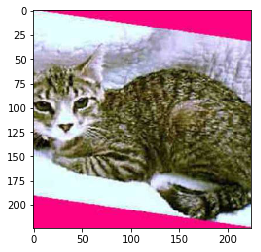

In [21]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [22]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [23]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

This matrix is produced to create the heat map. It's just equal to the value of the feature matrix `feat` times the `py` vector. Where `feat` is the relu of the last conv layer's activations, and `py` is simply eual to the predictions.

Multiplying `py` with `feat` zeros-out all dog predictions in the 2nd channel of the 2x7x7 tensor, and retrieves the cat predictions in the 1st.

Put another way, in our model the only thing that happened after the last Conv layer was an Average Pooling layer. That layer took the 7x7 grid and averaged out how much each part is cat-like. So the final prediction was the average cattiness of the entire image. Since it had to average it all; I can just take that input matrix (that it would average), and instead resize it to the image size and overlay it on top.

In [24]:
f2 = np.dot(np.rollaxis(feat, 0, 3), py)
f2 -= f2.min()
f2 /= f2.max()
f2

array([[0.07356, 0.1307 , 0.11601, 0.06211, 0.02402, 0.0131 , 0.     ],
       [0.26419, 0.39766, 0.35415, 0.23703, 0.15281, 0.10246, 0.04698],
       [0.53286, 0.76668, 0.6904 , 0.50032, 0.36571, 0.25737, 0.12887],
       [0.6803 , 1.     , 0.94347, 0.75207, 0.5958 , 0.44252, 0.23135],
       [0.5981 , 0.92257, 0.95296, 0.84157, 0.71871, 0.54337, 0.29031],
       [0.34725, 0.59102, 0.6866 , 0.67222, 0.60385, 0.45532, 0.23603],
       [0.08672, 0.19637, 0.27552, 0.30477, 0.2886 , 0.21152, 0.09147]], dtype=float32)

And the result of the Class Activation Map is a heat map of activations:

/home/wnixalo/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


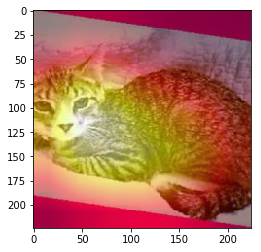

In [27]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

Woaaahhh Duuuuuude. Burning-man cat.

So a way you can use this is to calculate this convolutional feature matrix on some quick small ConvNet (say for a large image), zoom into the bit with the highest value, then rerun it on just that part of the image.

Note, `m.register_forward_hook` is a special PyTorch thing that runs the function/class it's in every time it calculates a layer -- it's like a callback that happens every time you calculate a layer. In our case, it just saves the value of the particular layer we're interested in via: `def hook_fn(self, module, input, output): self.features = to_np(output)`, allowing us to extract features. [PyTorch docs](http://pytorch.org/docs/master/) have more info on this.